#  Combined Cycle Plant Output and Ambient Site Conditions
- 9/6/2024
- Author:  Bill Louer
- Datasource:  https://www.kaggle.com/datasets/aagmandeep/combined-cycle-power-plant-dataset-and-prediction

<img src='https://www.ge.com/news/sites/default/files/4229.jpg' alt="Combined Cycle Power Plant" width="1000" height="750" >
Generic Combined Cycle Power Plant (Courtesy:  GE Power)

##  Table of Contents
1.  [Project Overview](#section-1) 
2.  [Data Input](#section-2)
3.  [Data Cleaning](#section-3)
4.  [Exploratory Data Analysis](#section-4)
5.  [Feature Engineering](#section-5)
6.  [Modeling and Evaluation](#section-6)
7.  [Findings and Conclusions](#section-7)

##  1. Project Overview <a class="anchor" id="section-1"></a>

###  Objectives:  
-  Evaluate the combined cycle dataset.
-  Analyze and observe the relationships between feature variables and the MW output.
-  Create a model to accurately predict plant capability (output) based on feature variables.
-  Test the accuracy of various models to predict MW output based on the feature variables and choose a final model.
-  Communicate the model results and accuracy of the MW output prediction model.

#### Dataset source:  https://www.kaggle.com/datasets/aagmandeep/combined-cycle-power-plant-dataset-and-prediction
##### Data Contents:
- The dataset comprises 9568 hourly average ambient environmental readings from sensors at a Combined Cycle Power Plant. 
- Temperature (T): Measurement Unit: Degrees Celsius (°C),  Description: Represents the ambient temperature.
- Ambient Pressure (AP): Measurement Unit: Milibar (mbar), Description: Indicates the atmospheric pressure.
- Relative Humidity (RH): Measurement Unit: Percentage (%), Description: Represents the relative humidity.
- Exhaust Vacuum (V): Measurement Unit: Centimeters of Mercury (cm Hg), Description: Indicates the level of vacuum in the exhaust of the turbine.
- Net Hourly Electrical Energy Output (PE): Measurement Unit: Megawatts (MW), Description: Hourly electrical energy produced by the Combined Cycle Power Plant

In [1]:
# !pip install psychrolib
# !pip install df2img
# !pip list
# !pip freeze > requirements.txt


In [2]:
#  import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats
import psychrolib
from psychrolib import GetTWetBulbFromRelHum
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

In [3]:
!pip uninstall pipreqs
# pipreqs --scan-notebooks /OneDrive/Work/DataScienceProjects/UTL000003_CombinedCycle/notebooks

In [4]:
# Set pandas display precision for floats
pd.set_option('display.precision', 3)  # Set to 2 decimal places

## 2. Data Input <a class="anchor" id="section-2"></a>

In [5]:
filepath = '../data/raw/CCPP_data.csv'
df = pd.read_csv(filepath)

In [6]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [8]:
#  Set up miscellaneous function so I can print dataframe tables for the report or presentation.
# This function requires work.  I need to format data columns with the appropriate number of significant digits before printing.
def print_table(df, sheetname):
    filepath = '../reports/results.xlsx'
    if os.path.exists(filepath):
        with pd.ExcelWriter(filepath, mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
            # Write DataFrame to a new sheet
            df.to_excel(writer, sheet_name=sheetname, index=False,  float_format="%.3f")
    else:
        with pd.ExcelWriter(filepath, mode='w', engine='openpyxl',) as writer:
            # Write DataFrame to a new sheet
            df.to_excel(writer, sheet_name=sheetname, index=False, float_format="%.3f")


## 3.  Data Cleaning <a class="anchor" id="section-3"></a>

In [9]:
#  change the column names
columns = ['amb_temp_C', 'cm_Hg', 'amb_press_mbar', 'rel_hum', 'output_MW']
df.columns = columns
df.head()

,amb_temp_C,cm_Hg,amb_press_mbar,rel_hum,output_MW
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [10]:
df.describe().reset_index()
print_table(df.describe().reset_index(), 'descriptive_stats')


In [11]:
#  check for NA values
df.isna().sum()

amb_temp_C        0
cm_Hg             0
amb_press_mbar    0
rel_hum           0
output_MW         0
dtype: int64

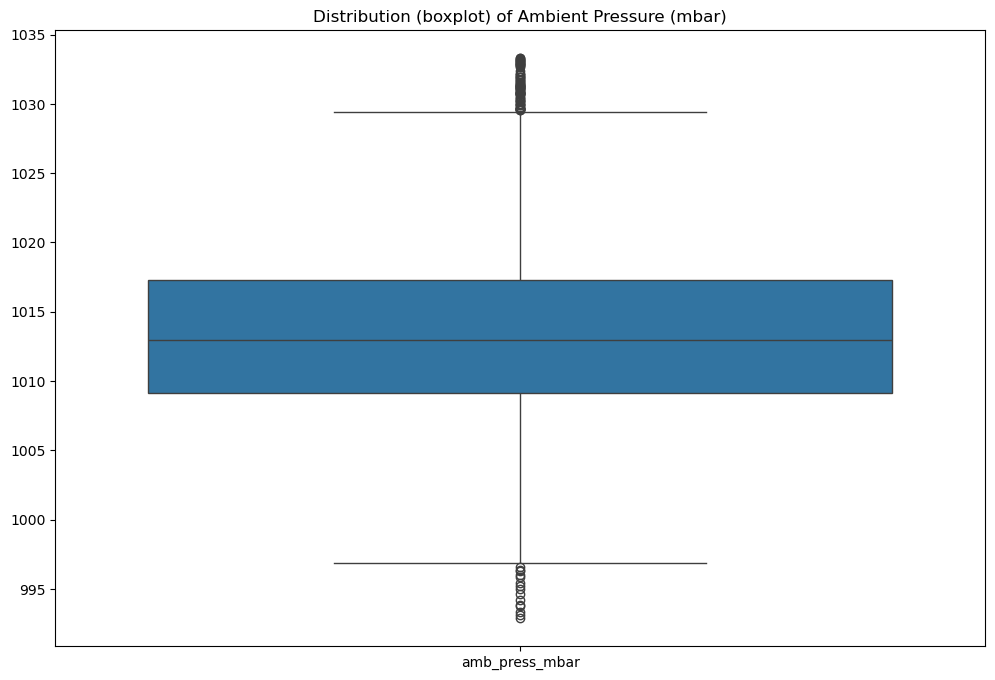

In [12]:
# Produce and save boxplots to show the distribution of each variables data.  Show where they may be outliers.
df_box = df[['amb_press_mbar']]
_, axs = plt.subplots(1, 1, figsize=(12,8))
sns.boxplot(data=df_box, ax=axs)
axs.set_title("Distribution (boxplot) of Ambient Pressure (mbar)")
plt.savefig('../reports/figures/boxplot_amb_press.png', dpi=300, bbox_inches='tight')
plt.show()

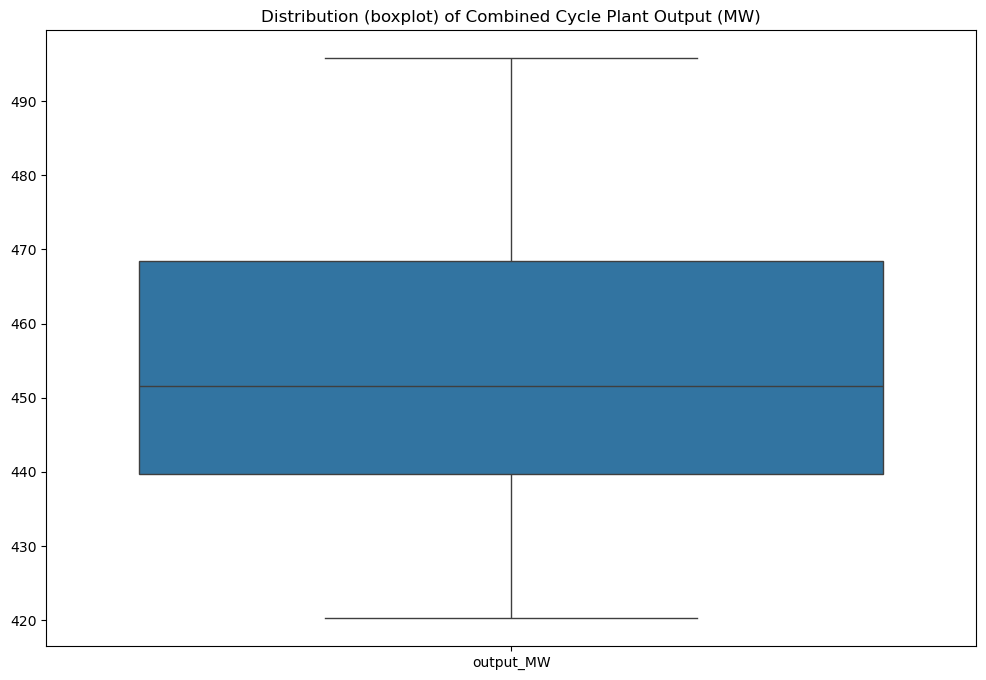

In [13]:
# Produce and save boxplots to show the distribution of each variables data.  Show where they may be outliers.
df_box = df[['output_MW']]
_, axs = plt.subplots(1, 1, figsize=(12,8))
sns.boxplot(data=df_box, ax=axs)
axs.set_title("Distribution (boxplot) of Combined Cycle Plant Output (MW)")
plt.savefig('../reports/figures/boxplot_output_MW.png', dpi=300, bbox_inches='tight')
plt.show()

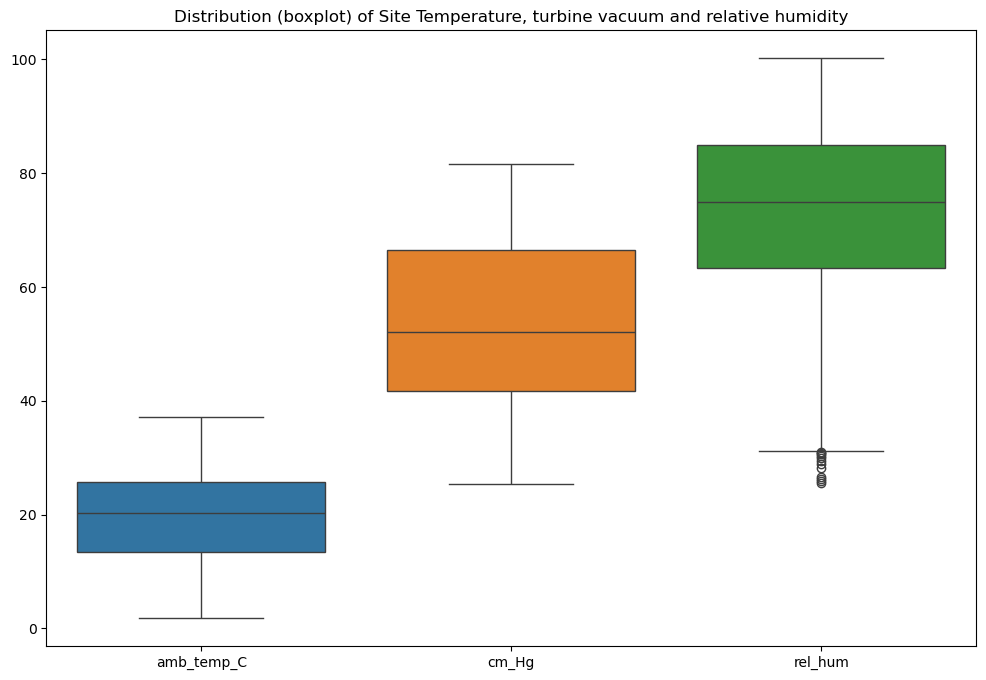

In [14]:
#  Look at outliers using a boxplot

df_box = df[['amb_temp_C', 'cm_Hg', 'rel_hum']]
_, axs = plt.subplots(1, 1, figsize=(12,8))
sns.boxplot(data=df_box, ax=axs)
axs.set_title("Distribution (boxplot) of Site Temperature, turbine vacuum and relative humidity")
plt.savefig('../reports/figures/boxplot_temp_vacuum_rh.png', dpi=300, bbox_inches='tight')
plt.show()

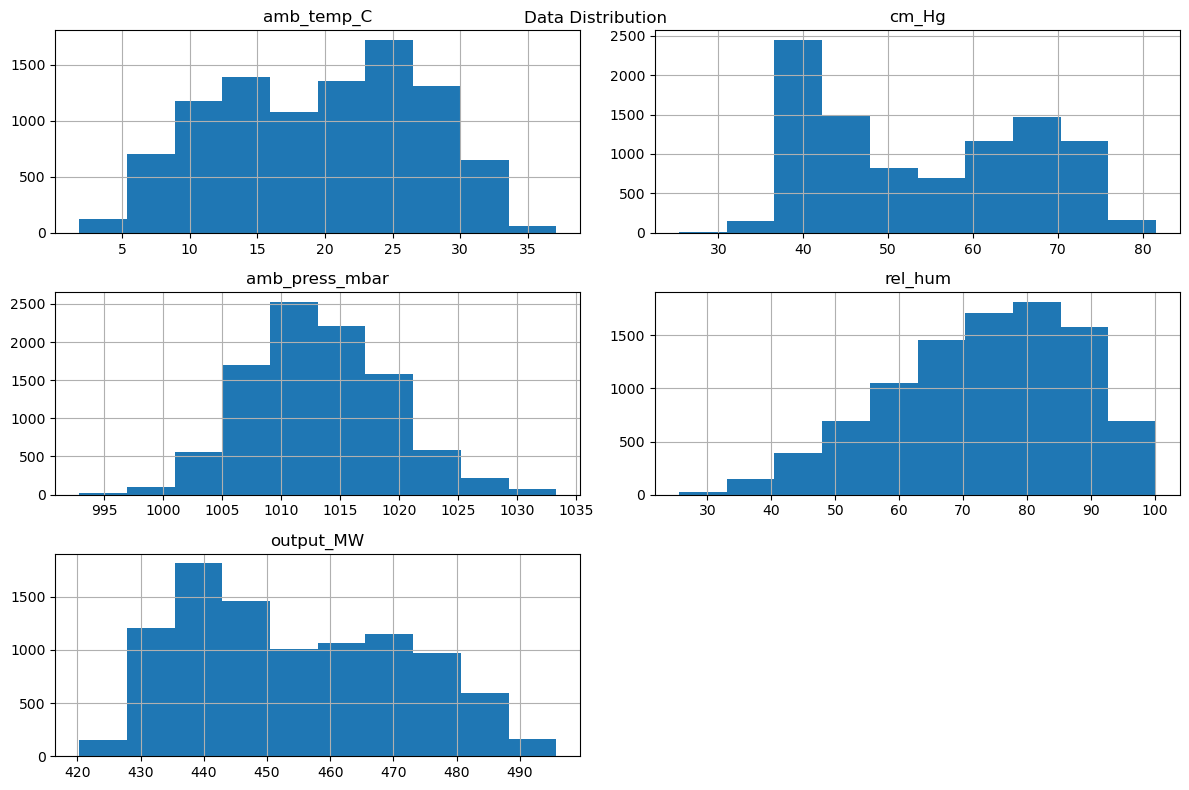

In [15]:
#  Create a histogram of each variable
df.hist(figsize=(12,8))
plt.tight_layout()
plt.suptitle('Data Distribution')
plt.show()

In [16]:
#  Identify outliers by z_scores
z_scores = stats.zscore(df)
df_outliers = abs(z_scores) > 3
df_outliers.any()

amb_temp_C        False
cm_Hg             False
amb_press_mbar     True
rel_hum            True
output_MW         False
dtype: bool

## 4. Exploratory Data Analysis <a class="anchor" id="section-4"></a>

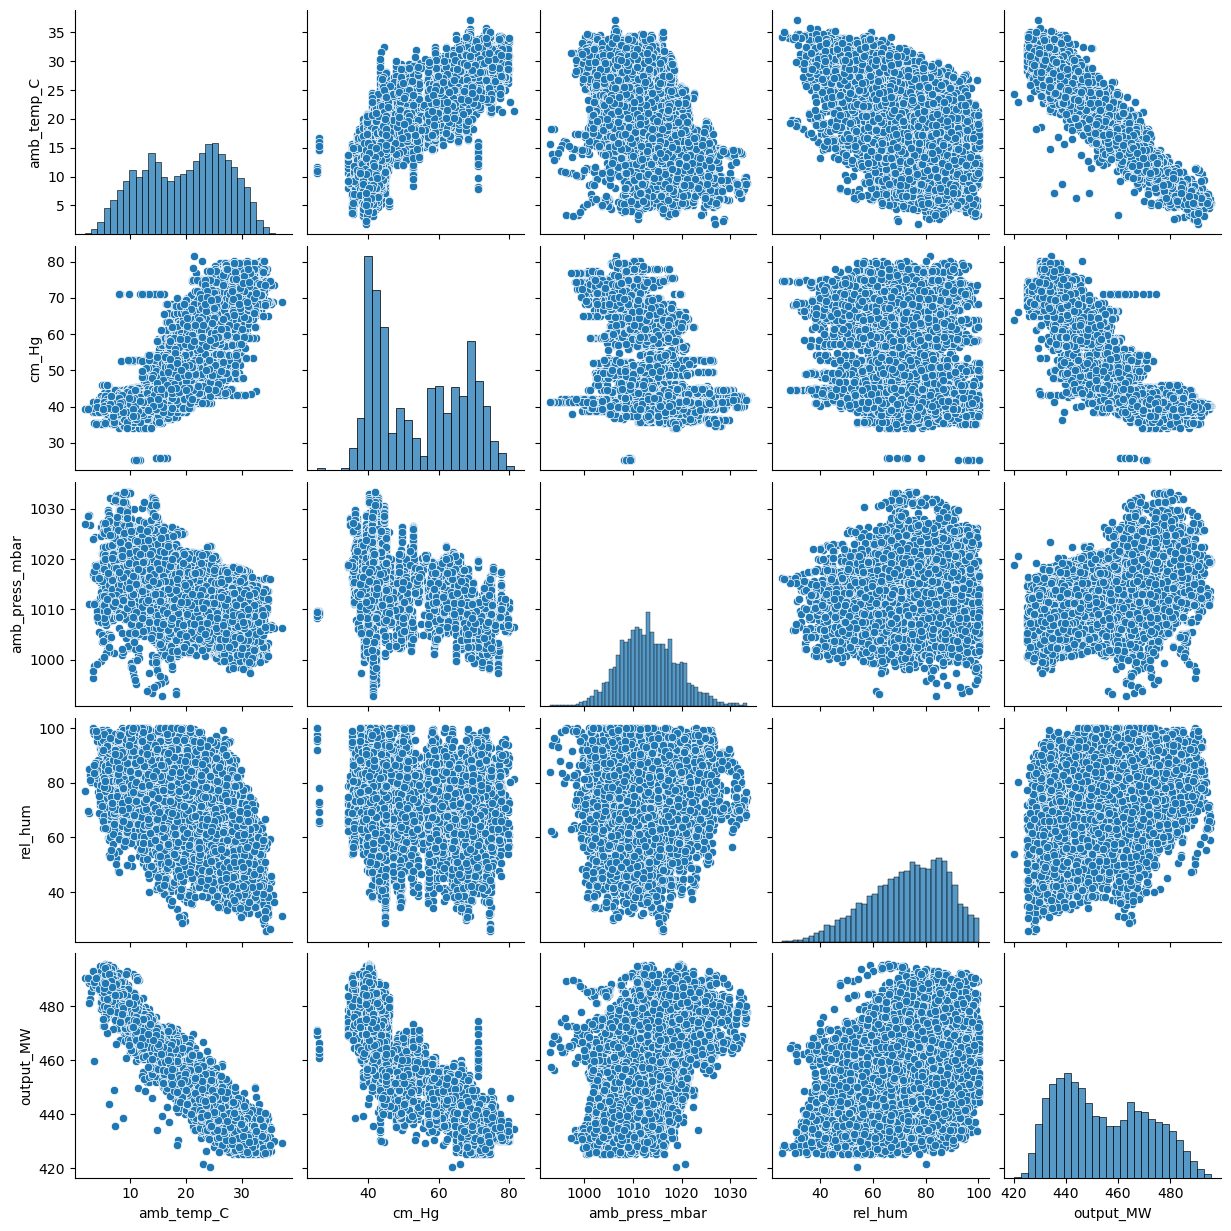

In [17]:
sns.pairplot(df)

## 5. Feature Engineering <a class="anchor" id="section-5"></a>

In [18]:
#  Convert rel_humidity to decimal, convert ambient Pressure to Pascals
df['rel_hum_fraction'] = df['rel_hum'] /df['rel_hum'].max()
df['amb_press_PA'] = df['amb_press_mbar'] * 100

In [19]:
#  Calculate wet bulb temperature from dry bulb, relative humidity and add this variable to the data.
psychrolib.SetUnitSystem(psychrolib.SI)  # Use SI units (Celsius, Pa)
df['wet_bulb_temp_C'] = df.apply(lambda row: GetTWetBulbFromRelHum(row['amb_temp_C'], row['rel_hum_fraction'], row['amb_press_PA']), axis=1)

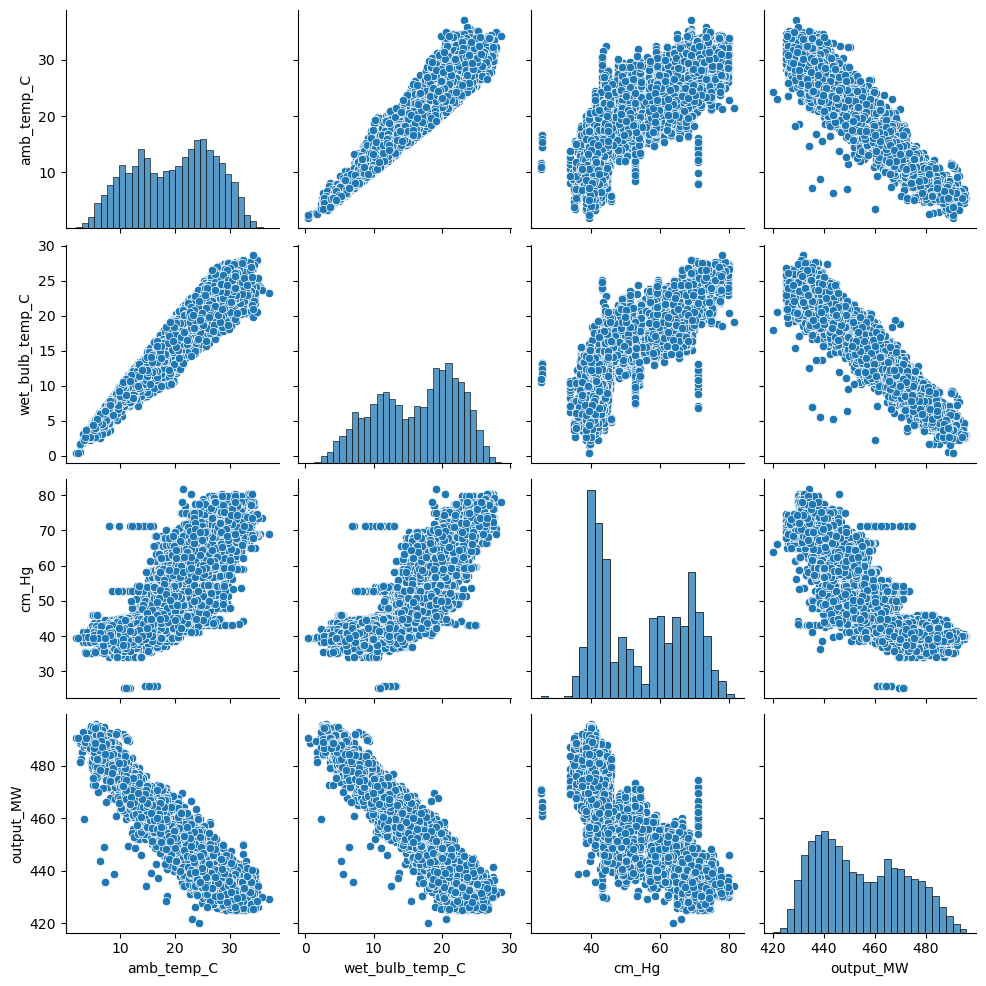

In [20]:
df = df[['amb_temp_C', 'wet_bulb_temp_C', 'amb_press_mbar', 'amb_press_PA', 'rel_hum_fraction', 'cm_Hg', 'output_MW']]
sns.pairplot(df[['amb_temp_C', 'wet_bulb_temp_C', 'cm_Hg', 'output_MW']])

#####  Output is dependent most on dry bulb, wet bulb and steam turbine backpressure (cm_Hg).  
#####  Lets check correlation and p_values for all features.

In [21]:
columns = list(df.columns)[:-1]
y_col = 'output_MW'
x_vars, y_vars, corr_coefs, p_vals = [], [], [], []
for col in columns:
    x_vars.append(col)
    y_vars.append('output_MW')
    coef, p_val = stats.pearsonr(df[col], df[y_col])
    corr_coefs.append(coef)
    p_vals.append(p_val)
df_corr_p_val = pd.DataFrame({'x_variable': x_vars, 'y_variable':y_vars, 'correlation_coef': corr_coefs, 'p_values': p_vals})
print_table(df_corr_p_val, 'correlation_p_vals')
df_corr_p_val

,x_variable,y_variable,correlation_coef,p_values
0,amb_temp_C,output_MW,-0.948,0.0
1,wet_bulb_temp_C,output_MW,-0.954,0.0
2,amb_press_mbar,output_MW,0.518,0.0
3,amb_press_PA,output_MW,0.518,0.0
4,rel_hum_fraction,output_MW,0.390,0.0
5,cm_Hg,output_MW,-0.870,0.0


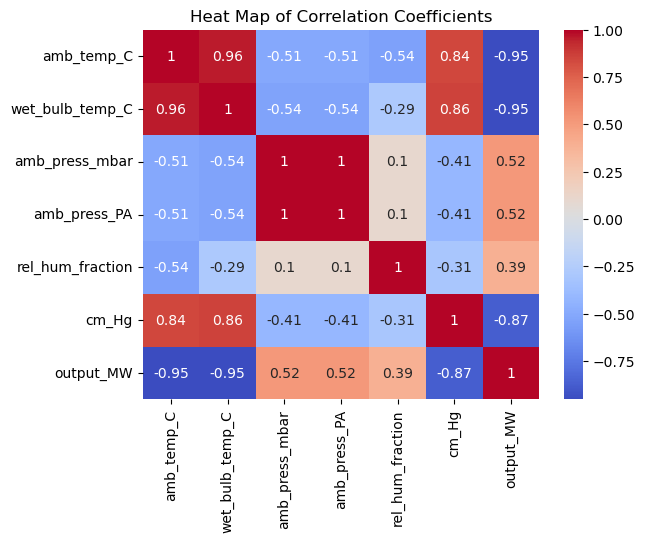

In [22]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heat Map of Correlation Coefficients')
plt.savefig('../reports/figures/corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

###  All of the values have good correlation and p_values so we will use all of the variables in the model except for rel_hum since its already accounted for in wet bulb temp.

#### Save the cleaned and featured data to a new csv file.

In [23]:
df.to_csv('../data/interim/CCPP_clean.csv', index=False )

####  Scale the feature variables in the data using standard scalar.

In [24]:
#  Create training and testing sets and then scale the feature variables.  This prevents data leakage (test data leaking into training the model.)
df_subset = df[['amb_temp_C', 'wet_bulb_temp_C', 'amb_press_PA', 'cm_Hg', 'output_MW']]
y = df_subset['output_MW']
scaler = StandardScaler()
X = df_subset.drop(columns='output_MW')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## 6. Modeling and Evaluation <a class="anchor" id="section-6"></a>

### Multiple Linear Regression Model without polynomial transformation of the data

In [25]:
#  Build Multiple linear regression model based on the X_train and y_train variables
#  Model assumes linear relation between target variable and features.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
mw_predict = lr_model.predict(X_test)
# Evaluate the model
lr_mse = mean_squared_error(y_test, mw_predict)
lr_mae = mean_absolute_error(y_test, mw_predict)
lr_r2 = r2_score(y_test, mw_predict)
#  Print mean squared error and r squared
print(f"Mean Squared Error: {lr_mse:.04f}")
print(f"Mean Absolute Error: {lr_mae:.04f}")
print(f"R-squared: {lr_r2:.04f}")

# Print coefficients
print('Independent Variables:', list(X_train.columns))
print("Coefficients:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)

Mean Squared Error: 19.6742
Mean Absolute Error: 3.5558
R-squared: 0.9322
Independent Variables: ['amb_temp_C', 'wet_bulb_temp_C', 'amb_press_PA', 'cm_Hg']
Coefficients: [-8.70188397e-01 -1.24193800e+00  6.17751404e-04 -2.24702964e-01]
Intercept: 441.2555581084612


In [26]:
#  plot a kde plot of predicted MW and the actual MW
def plot_test_prediction_distribution(y_test, y_predict, model_type, mse, mae, r2):
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    sns.set(style="whitegrid")
    sns.kdeplot(ax=axs[0], x=y_test, color="r", label="Actual Values")
    sns.kdeplot(ax=axs[0], x=y_predict, color="b", label="Predicted Value")
    
    axs[0].set_title(f'Distribution Plot ({model_type})\nOut-of-Sample Predicted vs. Actual Test Data',  fontsize=10, color='black')
    axs[0].annotate(f'Model Fit:\nMSE:  {mse:.04f} \nMAE: {mae:.01f}\nR2:  {r2:.03f}', xy=(0.65, 0.85), xycoords='axes fraction',
                       fontsize=10, color='black', ha='left', va='top')
    axs[0].legend()
    
    axs[1].scatter(mw_predict, y_test, alpha = 0.4)
    axs[1].set_title(f'Predicted vs. Actual\n({model_type})')
    axs[1].set_xlabel('Model Predicted MW Output')
    axs[1].set_ylabel('Actual MW Output')
    plt.savefig(f'../reports/figures/{model_type}_kde.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
#  Show a distribution of the percent error of the prediction and the confidence interval on the kde plot.
def plot_error_distribution(y_test, y_predict, model_type, lwr_pct=2.5, uppr_pct=97.5):
    '''Plot the error distribution given the test data set and predicted data set'''
    variance_pct = 100*(y_test - y_predict)/y_test
    plt.figure(figsize=(10,5))
    sns.kdeplot(x=variance_pct, fill=False, color="blue", label="Variance Distribution")
    plt.title(f'Distribution of Percent Error\nModel Type:  {model_type}')
    plt.xlabel('Percent Error')
    
    # Compute the KDE values and x-axis values
    kde = stats.gaussian_kde(variance_pct)
    x_vals = np.linspace(min(variance_pct), max(variance_pct), 1000)
    kde_vals = kde(x_vals)
    
    # Calculate the percentiles for the middle 90% (5th and 95th percentiles)
    lower_bound = np.percentile(variance_pct, lwr_pct)
    upper_bound = np.percentile(variance_pct, uppr_pct)
    
    # Plot the KDE
    plt.plot(x_vals, kde_vals, color='blue')
    
    # Shade the middle 90%
    plt.fill_between(x_vals, kde_vals, where=(x_vals >= lower_bound) & (x_vals <= upper_bound), 
                     color='blue', alpha=0.3)
    
    # Highlight the percentile values on the x-axis
    plt.axvline(lower_bound, color='red', linestyle='--', label=f'2.5th percentile: {lower_bound:.01f}% Error')
    plt.axvline(upper_bound, color='red', linestyle='--', label=f'97.5th percentile: {upper_bound:.01f}% Error')
    
    plt.legend()
    plt.savefig(f'../reports/figures/{model_type}_error_dist.png', dpi=300, bbox_inches='tight')
    plt.show()

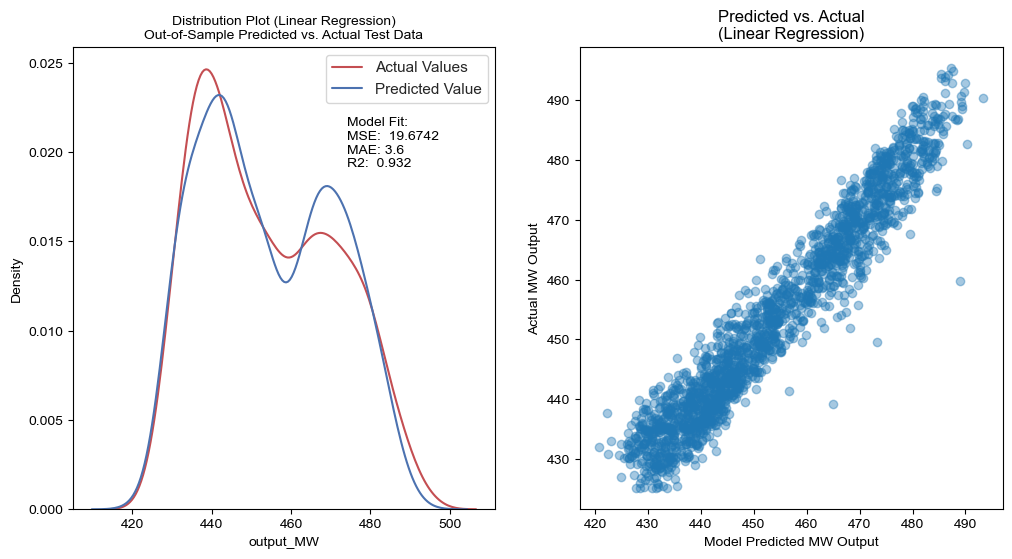

In [28]:
plot_test_prediction_distribution(y_test, mw_predict, 'Linear Regression', lr_mse, lr_mae, lr_r2)

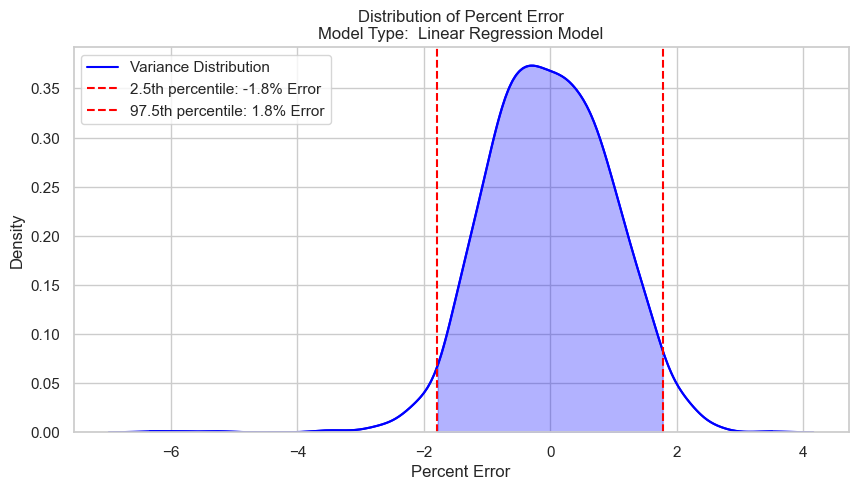

In [29]:
plot_error_distribution(y_test, mw_predict, 'Linear Regression Model',  lwr_pct=2.5, uppr_pct=97.5)

Conclusions from Multiple Linear Regression:
-  Very good fit.
-  Model seems to be predicting between +/- 1.8% for 95% of the time (2 std deviations from the mean).
-  Compare vs. other model types

####  Gradiant Boosting Machine

In [30]:
GBM_model = GradientBoostingRegressor()
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Set up the GridSearch
grid_search = GridSearchCV(estimator=GBM_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)
GBM_mw_predict = grid_search.predict(X_test)

GBM_mse = mean_squared_error(y_test, GBM_mw_predict)
GBM_mae = mean_absolute_error(y_test, GBM_mw_predict)
GBM_r2 = r2_score(y_test, GBM_mw_predict)
#  Print mean squared error and r squared
print(f"Mean Squared Error: {GBM_mse:.04f}")
print(f"Mean Absolute Error: {GBM_mae:.04f}")
print(f"R-squared: {GBM_r2:.04f}")
print(grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean Squared Error: 12.9528
Mean Absolute Error: 2.7377
R-squared: 0.9553
{'learning_rate': 0.1, 'n_estimators': 200}


##### Without GridSearch:
- Mean Squared Error: 14.5428- 
Mean Absolute Error: 2.948
- 
R-squared: 0.94
##### With GridSearch:
- Mean Squared Error: 12.9511
- 
Mean Absolute Error: 2.737
- 
R-squared: 0.9553319


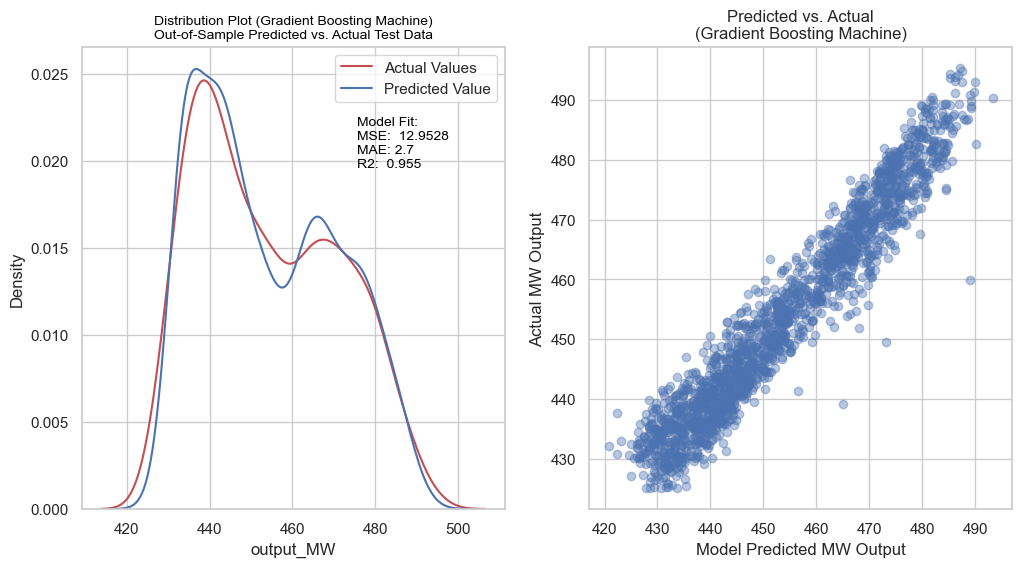

In [31]:
plot_test_prediction_distribution(y_test, GBM_mw_predict, 'Gradient Boosting Machine', GBM_mse, GBM_mae, GBM_r2)

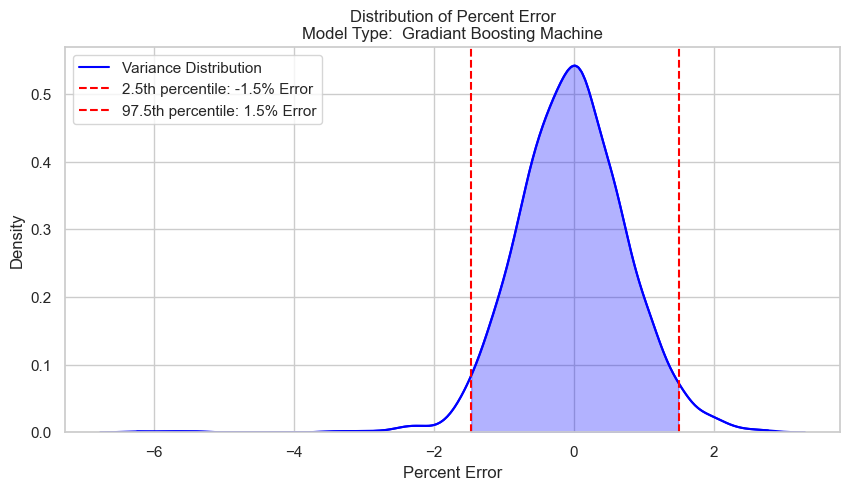

In [32]:
plot_error_distribution(y_test, GBM_mw_predict, 'Gradiant Boosting Machine', lwr_pct=2.5, uppr_pct=97.5, )

#### Random Forest Regressor

In [33]:
RFR_model = RandomForestRegressor()
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

# Set up the GridSearch
RFR_grid_search = GridSearchCV(estimator=RFR_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
RFR_grid_search.fit(X_train, y_train)
RFR_mw_predict =  RFR_grid_search.predict(X_test)
RFR_mse = mean_squared_error(y_test, RFR_mw_predict)
RFR_mae = mean_absolute_error(y_test, RFR_mw_predict)
RFR_r2 = r2_score(y_test, RFR_mw_predict)
#  Print mean squared error and r squared
print(f"Mean Squared Error: {RFR_mse:.04f}")
print(f"Mean Absolute Error: {RFR_mae:.04f}")
print(f"R-squared: {RFR_r2:.04f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean Squared Error: 10.3259
Mean Absolute Error: 2.2802
R-squared: 0.9644


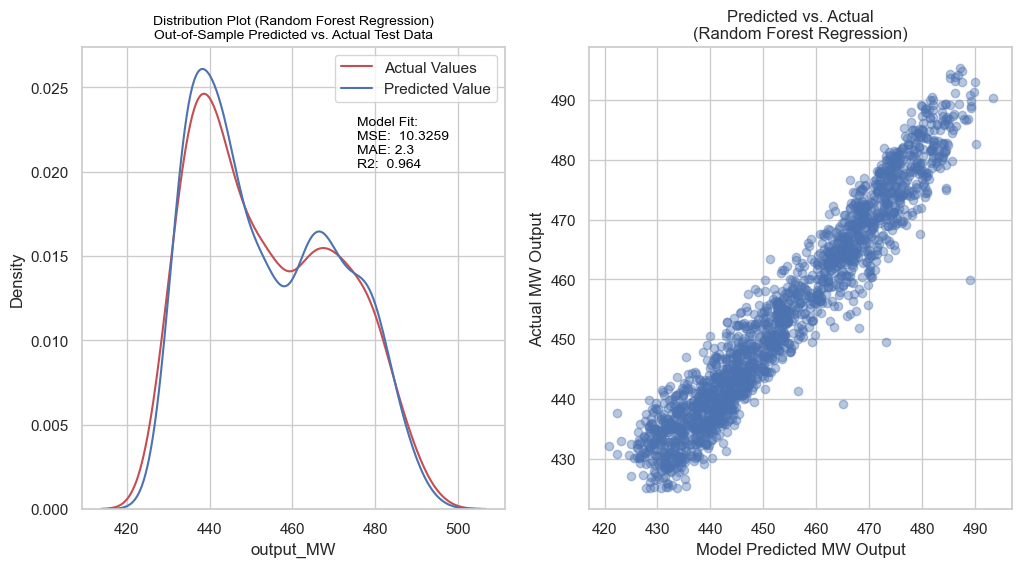

In [34]:
plot_test_prediction_distribution(y_test, RFR_mw_predict, 'Random Forest Regression', RFR_mse, RFR_mae, RFR_r2)

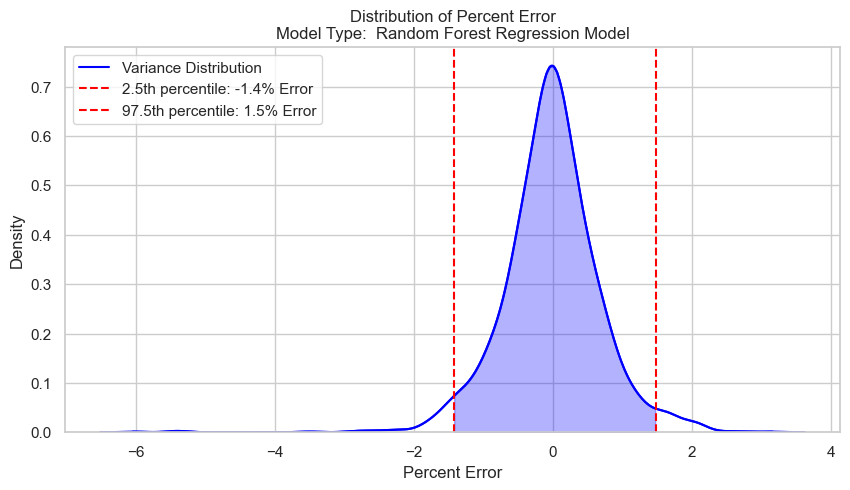

In [35]:
plot_error_distribution(y_test, RFR_mw_predict, 'Random Forest Regression Model', lwr_pct=2.5, uppr_pct=97.5, )

In [36]:
#  Document the model results in a table and a bar chart to compare model performance.
model_types = ['Linear Regression', 'Gradiant Boosting Machine', 'Random Forest Regression']
r2_results =  [lr_r2, GBM_r2, RFR_r2]
mae_results = [lr_mae, GBM_mae, RFR_mae]
mse_results = [lr_mse, GBM_mse, RFR_mse]
df_results = pd.DataFrame({'Model Type': model_types, 'R Squared': r2_results, 'Mean Absolute Error': mae_results, 'Mean Squared Error': mse_results})
print_table(df_results, 'model_results')
df_results

,Model Type,R Squared,Mean Absolute Error,Mean Squared Error
0,Linear Regression,0.932,3.556,19.674
1,Gradiant Boosting Machine,0.955,2.738,12.953
2,Random Forest Regression,0.964,2.280,10.326


## 7. Findings and Conclusions <a class="anchor" id="section-7"></a>

Data on combined cycle output and associated ambient site conditions and turbine backpressure was evaluated.  The following overservations and conclusions could be made:
-  Combined cycle plant output is primary dependent on ambient dry bulb temperature, ambient wet-bulb temperature and turbine backpressure.
-  The dataset was reviewed and checked for NaN values and outliers using a box plot.
-  The number of outliers was not significant and the outliers were kept in the dataset for modeling.
-  3 different types of models were evaluated, each with very good fits.
-  Multiple linear regression resulted in an R_squared vale of 0.932.  The resultant predictions were within 1.8% of actual MW 95% of the time.
-  A Gradiant Boosting Machine model resulted in an R_squared vale of 0.955.  The resultant predictions were within 1.5% of actual MW 95% of the time.
-  A Random Forest regression model resulted in an R_squared vale of 0.965.  The resultant predictions were within 1.4% of actual MW 95% of the time.
-  The Random Forest Regression model is the best model and can be used to predict combined cycle plant performance.

### Thoughts on Future Work and Next Steps:
-  While a prediction which yields +/- 1.4% of output seems very accurate, a more refined estimate of plant output could be possible.
-  Other plant operation data could be collected and reviewed to improve model fit.
-  Data which has could have an impact on plant output could include the following:
    - Evaporative Cooling Operation Status.
    - Gas turbine air inlet filter differential pressure.
    - HRSG blowdown percent or blowdown valve position.
    - High and Intermediate Pressure Steam, Pressure and Temperature
    - Any steam bleeds or cycle heating circuits whose operation could impact plant output
    - Additional review of data as necessary to determine corrlation.

###  Acknowledgements:
-  This work relies on a dataset that was made available on kaggle from Mr. Aagman Bhatia (https://www.kaggle.com/aagmandeep) with associated references (noted above).  Mr. Bhatia's contribution is appreciated.
